In [56]:
!pip install -Uq grpcio==1.26.0

     |████████████████████████████████| 2.4MB 5.7MB/s 
ERROR: tensorflow 2.4.1 has requirement grpcio~=1.32.0, but you'll have grpcio 1.26.0 which is incompatible.


In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *

import numpy as np
import matplotlib.pyplot as plt
import os
import tempfile

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [3]:
x_train = x_train/ 255.0
x_test = x_test/ 255.0

In [4]:
# Add a final dimension to the arrays
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

In [5]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [6]:
model = Sequential([
                    Conv2D(8, 3, 2, activation='relu', name='conv1', input_shape=(28,28,1)),
                    Flatten(),
                    # No activation function specified, so no activation is applied and logits are returned
                    Dense(10, name='Dense')
])

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 13, 13, 8)         80        
_________________________________________________________________
flatten (Flatten)            (None, 1352)              0         
_________________________________________________________________
Dense (Dense)                (None, 10)                13530     
Total params: 13,610
Trainable params: 13,610
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, verbose=1)

Epoch 1/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.7467 - sparse_categorical_accuracy: 0.7534 - val_loss: 0.4309 - val_sparse_categorical_accuracy: 0.8477
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3927 - sparse_categorical_accuracy: 0.8629 - val_loss: 0.3854 - val_sparse_categorical_accuracy: 0.8640
Epoch 3/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3478 - sparse_categorical_accuracy: 0.8771 - val_loss: 0.3717 - val_sparse_categorical_accuracy: 0.8672
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3262 - sparse_categorical_accuracy: 0.8842 - val_loss: 0.3540 - val_sparse_categorical_accuracy: 0.8727
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3067 - sparse_categorical_accuracy: 0.8899 - val_loss: 0.3476 - val_sparse_categorical_accuracy: 0.8767


In [8]:
# Get the temp directory of the server (/tmp)
MODEL_DIR = tempfile.gettempdir()
version = 1
# Path to export the model to
export_path = os.path.join(MODEL_DIR, str(version))
print(f'Exported to: {export_path}')

Exported to: /tmp/1


In [132]:
print(MODEL_DIR)

/tmp


In [50]:
# Must save tf model to a SavedModel format for tf serving to use it

tf.keras.models.save_model(model, export_path, overwrite=True, include_optimizer=True,     save_format=None,
    signatures=None,
    options=None)
!ls -l {export_path}

INFO:tensorflow:Assets written to: /tmp/1/assets
total 88
drwxr-xr-x 2 root root  4096 Mar 26 00:22 assets
-rw-r--r-- 1 root root 78053 Mar 26 00:59 saved_model.pb
drwxr-xr-x 2 root root  4096 Mar 26 00:59 variables


In [51]:
# saved_model_cli is from tf, gives more info about the saved_model
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['conv1_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: serving_default_conv1_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['Dense'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
W0326 00:59:46.642805 139809400629120 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/python/

In [52]:
import sys

# We need sudo prefix if not on a Google Colab.
if 'google.colab' not in sys.modules:
  SUDO_IF_NEEDED = 'sudo'
else:
  SUDO_IF_NEEDED = ''

In [12]:
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | {SUDO_IF_NEEDED} tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | {SUDO_IF_NEEDED} apt-key add -
!{SUDO_IF_NEEDED} apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0   110k      0 --:--:-- --:--:-- --:--:--  110k
OK
Hit:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease
Hit:2 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hi

In [13]:
!{SUDO_IF_NEEDED} apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tensorflow-model-server is already the newest version (2.4.1).
0 upgraded, 0 newly installed, 0 to remove and 59 not upgraded.


In [14]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [69]:
%%bash --bg
nohup tensorflow_model_server \
  --rest_api_port=8502 \
  --model_name=fashion_mnist \
  --model_base_path="${MODEL_DIR}" > server.log 2>&1

Starting job # 8 in a separate thread.


In [71]:
!tail server.log

2021-03-26 01:05:53.645144: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:206] Restoring SavedModel bundle.
2021-03-26 01:05:53.646175: I external/org_tensorflow/tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2299995000 Hz
2021-03-26 01:05:53.673693: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:190] Running initialization op on SavedModel bundle at path: /tmp/1
2021-03-26 01:05:53.678414: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:277] SavedModel load for tags { serve }; Status: success: OK. Took 60790 microseconds.
2021-03-26 01:05:53.679164: I tensorflow_serving/servables/tensorflow/saved_model_warmup_util.cc:59] No warmup data file found at /tmp/1/assets.extra/tf_serving_warmup_requests
2021-03-26 01:05:53.679316: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: fashion_mnist version: 1}
2021-03-26 01:05:53.680745: I tensorflow_serving/model_servers/server.cc:371] 

In [77]:
def show(idx, title):
  plt.figure()
  plt.imshow(x_test[idx].reshape(28,28))
  plt.axis('off')
  plt.title(f'\n\n{title}', fontdict={'size':16})

In [87]:
import random
import json
import requests

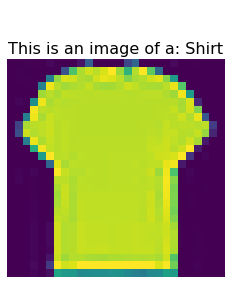

In [80]:
rn = random.randint(0, len(x_test)-1)
show(rn, f'This is an image of a: {class_names[y_test[rn]]}')

In [113]:
x_test[0:3].reshape(-1,28,28,1).shape

(3, 28, 28, 1)

In [114]:
sample_idx = 2

data = json.dumps({"signature_name": "serving_default", "instances": x_test[sample_idx].reshape(-1,28,28,1).tolist()})

In [115]:
headers = {'content-type': "application/json"}
res = requests.post('http://localhost:8502/v1/models/fashion_mnist:predict', data=data, headers=headers)

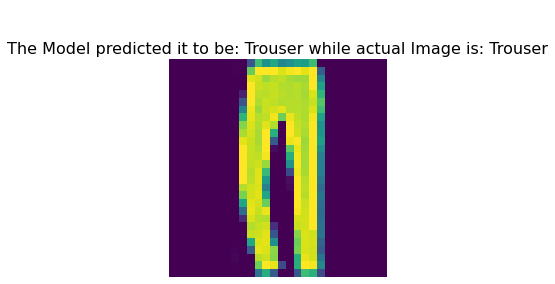

In [117]:
preds = json.loads(res.text)['predictions']
show(sample_idx, f'The Model predicted it to be: {class_names[np.argmax(preds[0])]} while actual Image is: {class_names[y_test[sample_idx]]}')

In [98]:
np.argmax(preds[0])

9